In [1]:
import pfTent as tent
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pandas as pd

## Summary stats & power calcs: Another stab
I have a model that is working-ish, and I'd really like to move forward on doing power calculations.
The first step of doing power calcs is having a summary statistic that I feel confident moving forward with.
But a problem that I have continually run into on this project is having a scattered codebase with everything
all over the place. To address, this I'm going to move forward on doing the above, but I'm actually going to write
quality code to add into the final .py

1. Write code to get first vs. second infection timepoints:
- For real
- For measured

Measured can just be first time seen, gap when not seen, next time seen.
Real could be max of first & second infections, all the times in first & second infections.

In [2]:
y=3
a = [10,10,10,10]
w = [0,1/3,1/3,1/3]
eir=40

In [3]:
fever,breaks = tent.load_data()
fever_arr = tent.get_fever_arr(eir,fever,breaks)
pmatrix, smatrix, imatrix, malaria,infectmatrix = tent.simulate_person(y,a,w,fever_arr)

/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/pfTent.py:161: RuntimeWarning: divide by zero encountered in reciprocal
  new_param = param/(c/np.tan(np.pi/2*x)**b+1)


In [4]:
malaria

[12, 43, 70, 90, 112, 143, 178, 609]

In [5]:
def get_visits(malaria,period,y):
    '''
    Returns passive & active visit dates in a list.
    '''
    start = np.random.randint(1,period)
    if start > malaria[0]:
        start = malaria[0]
    active = set(range(start,y*365,period))
    visits = list(active.union(set(malaria)))
    visits.sort()
    return visits

In [6]:
visits = get_visits(malaria,28,y)

In [7]:
def get_infection_windows(loci, allele, pmatrix, visits=[],infectmatrix=[],smatrix=[],n_infections=2):
    '''
    Returns(2,n_infection) with time range for given n_infections at given loci & given allele.
    start = first day, end = last day ([,])
    If visits provided, start & end correspond to measured timepoints.
    If infectmatrix is provided, start & end correspond to true times.
    '''
    windows = np.zeros((2,n_infections),dtype=int) - 1
    
    if len(visits)>0:
        values = pmatrix[loci,allele,visits]
        positiveVisits = values.nonzero()[0]
        if len(positiveVisits):
            windows[0,0] = visits[positiveVisits[0]]
            shifted = np.roll(positiveVisits,1)
            test = positiveVisits-shifted
            new = np.where(test>1)[0]
            for i in range(0,n_infections):
                if i<len(new):
                    windows[1,i] = visits[positiveVisits[new[i]-1]]
                    if i-1 >= 0:
                        windows[0,i] = visits[positiveVisits[new[i-1]]]
                else:
                    windows[1,i-1] = visits[positiveVisits[-1]]
        
    elif len(infectmatrix)>0 and len(smatrix)>0:
        bites = np.where(infectmatrix[loci+1,:] == allele)[0] # bites are locations where you get an infection at that allele
        day = infectmatrix[0,bites[0]]
        windows[0,0] = day
        windows[1,0] = smatrix[bites[0],:].nonzero()[0][-1]
        counter = 0
        
        for i in range(1,len(bites)):
            new_day = infectmatrix[0,bites[i]]
            if new_day != day:
                if i-counter < n_infections:
                    windows[0,i-counter] = new_day
                    windows[1,i-counter] = smatrix[bites[i],:].nonzero()[0][-1]
                day = new_day
            else:
                counter += 1

    else:
        print("Must provide visits or infectmatrix & smatrix. If visits, will return measured time range of exposures. If infectmatrix & smatrix, will return true time range of exposures.")
   
    return windows

[[ 90 178]
 [ 90 178]]
[[178 320]
 [178 376]]
[[143 236]
 [143 404]]
[[ 40 208]
 [ 43 609]]
[[264 656]
 [516 880]]
[[112 320]
 [112 404]]
[[208 516]
 [432 572]]
[[ 40 178]
 [ 70 178]]
[[12 68]
 [12 70]]
[[264 600]
 [404 609]]


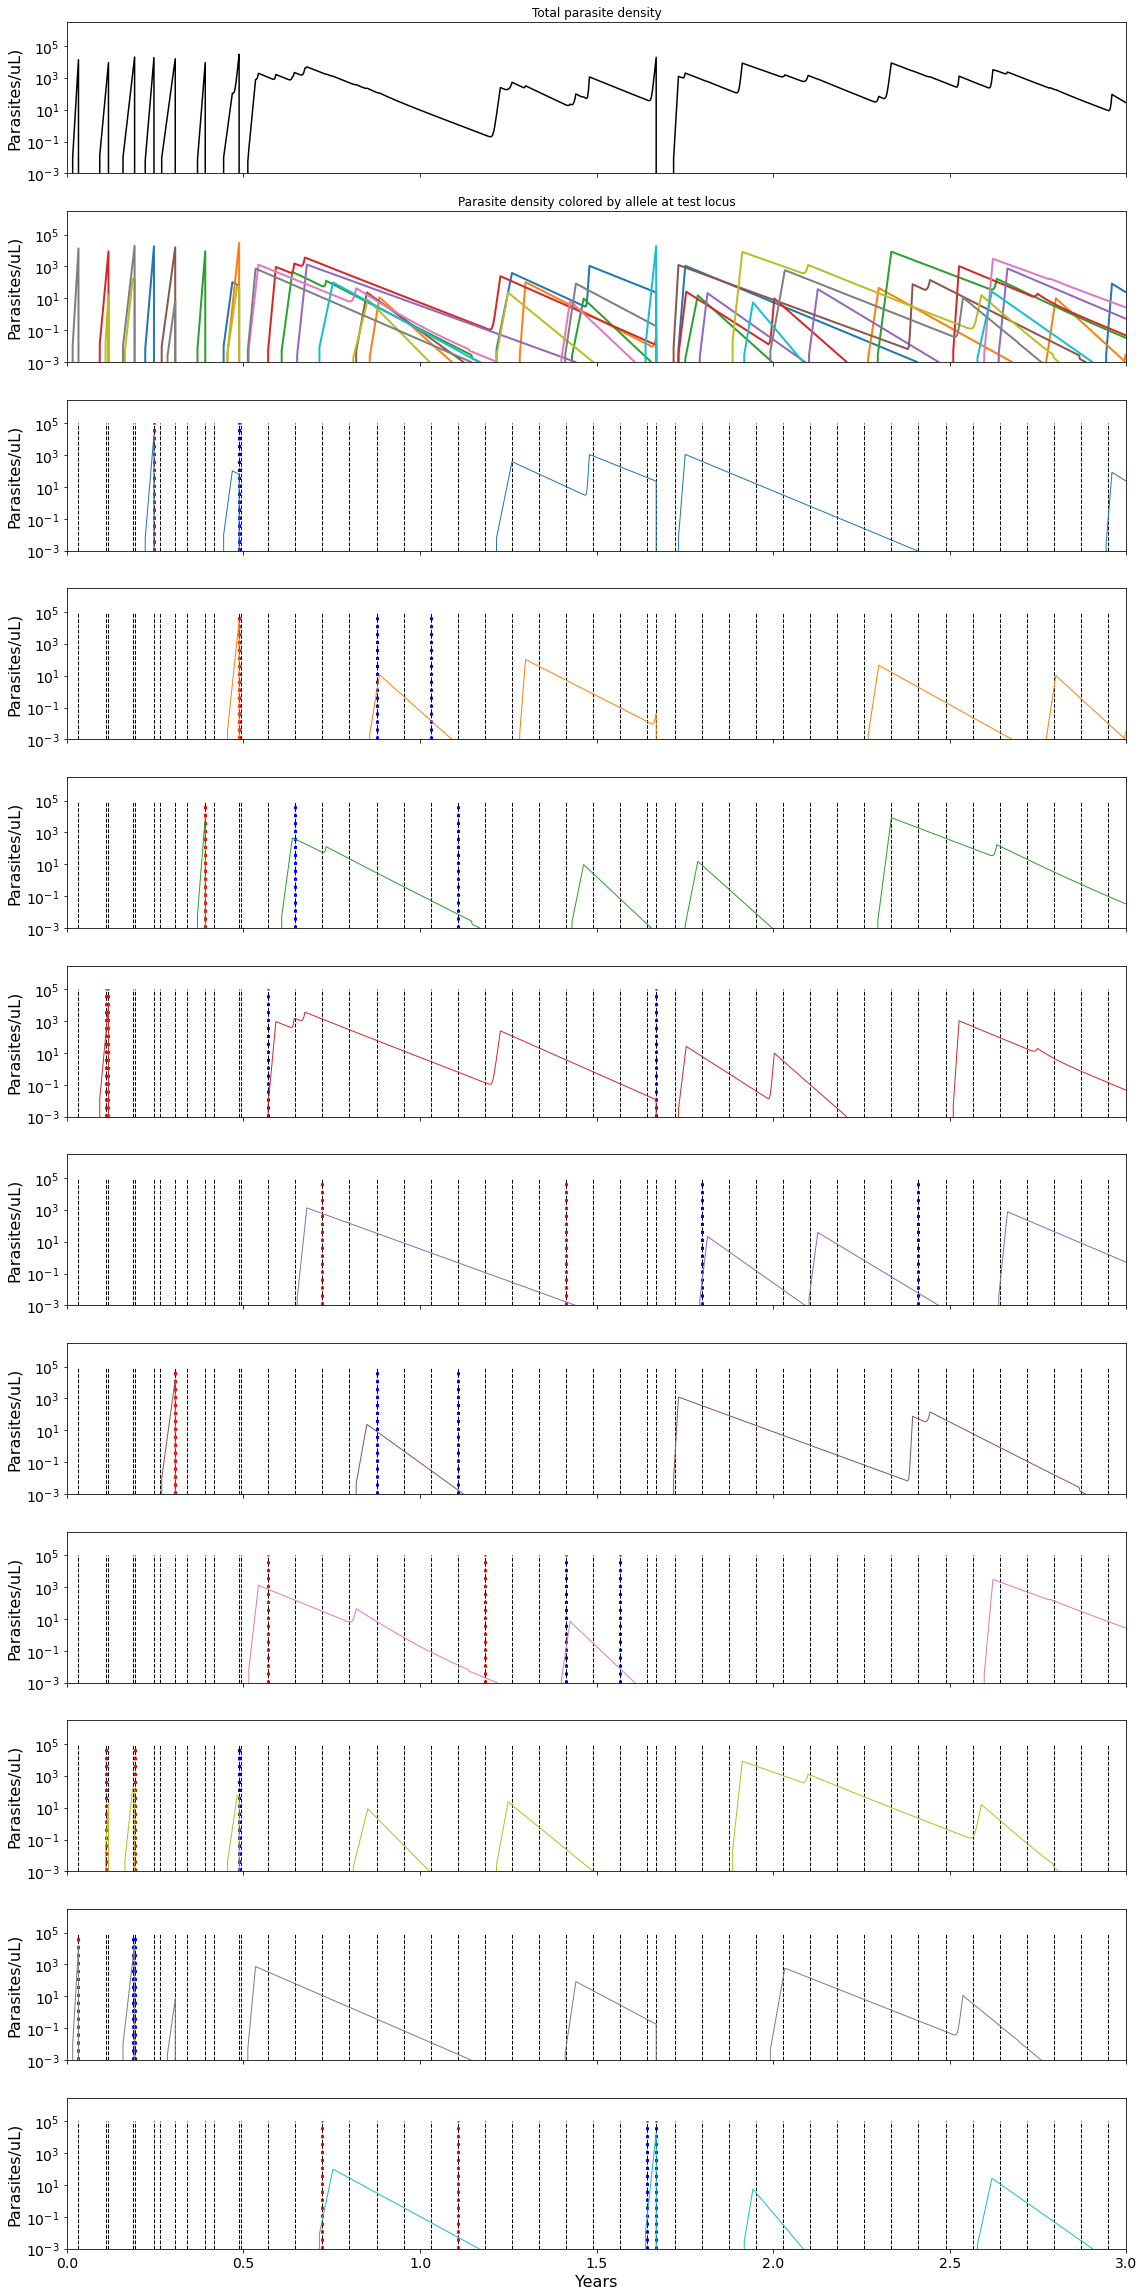

In [8]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

fig, ax = plt.subplots(nrows=12, sharey=True, sharex=True, tight_layout=True, figsize=(16,32))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')
ax[0].plot(np.arange(y*365)/365, pmatrix[-1,:,:].sum(axis=0),color="black")
for strain in np.arange(10):
    iStrain = pmatrix[-1,strain,:]
    if np.sum(iStrain) > 1:
        ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
ax[0].set_ylim(0.001,3000000)
ax[0].set_xlim(0,3)
#fig.suptitle('person ' + str(i),fontsize=18)
ax[11].set_xlabel('Years',fontsize=16)
ax[0].set_ylabel('Parasites/uL)',fontsize=16)
ax[0].set_title('Total parasite density')
ax[1].set_title('Parasite density colored by allele at test locus')
ax[1].set_ylabel('Parasites/uL)',fontsize=16)
for row in range(2,12):
    windows = get_infection_windows(3,row-2,pmatrix,visits=visits)
    print(windows)
    ax[row].tick_params(axis='both', which='major', labelsize=14)
    ax[row].set_ylabel('Parasites/uL)',fontsize=16)
    other = [strain for strain in range(0,10) if strain != row-2]
    ax[row].plot(np.arange(y*365)/365, pmatrix[-1,row-2,:],linewidth=1,color=colors[row-2])
    ax[row].vlines(x=np.asarray(visits)/365,ymin=0.001,ymax=100000,color="black",linestyle="dashed",linewidth=1)
    ax[row].vlines(x=windows[:,0]/365,ymin=0.001,ymax=100000,color="red",linewidth=3,linestyle="dotted")
    ax[row].vlines(x=windows[:,1]/365,ymin=0.001,ymax=100000,color="blue",linewidth=3,linestyle="dotted")

2. Is there a difference in immunity at first vs. second exposure?

We can only use the "real" or true time range here as a timepoint during the the infection would have an immunity = 1.

In [9]:
n_people = 100
immune_loci = len(a)-1
all_parasites, all_immunity, all_strains, all_malaria, all_infections = tent.simulate_cohort(n_people,y,a,w)

/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/pfTent.py:161: RuntimeWarning: divide by zero encountered in reciprocal
  new_param = param/(c/np.tan(np.pi/2*x)**b+1)


In [10]:
immunity = np.empty((immune_loci*max(a)*n_people,10))
immunity[:,:] = np.nan
counter = 0
for person in range(n_people):
    for loci in range(1,len(a)):
        for allele in range(a[loci]):
            windows= get_infection_windows(loci, allele, all_parasites[person,...], infectmatrix=all_infections[person],n_infections=10,smatrix=all_strains[person])
            starts = windows[0,:]
            for i in range(10):
                if starts[i] > 0:
                    immunity[counter,i] = all_immunity[person,loci,allele,starts[i]]
            counter += 1

In [11]:
immunity.shape

(3000, 10)

In [12]:
exposures = np.tile(range(0,10),immunity.shape[0])
immunity_long = immunity.flatten()
exps = []
imms = []
for e, i in zip(exposures,immunity_long):
    if not np.isnan(i):
        exps.append(e)
        imms.append(i)
exps = np.asarray(exps)
imms = np.asarray(imms)

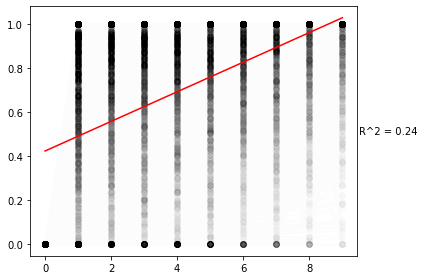

In [13]:
slope, intercept, r, p, se = st.linregress(exps,imms)
x = np.asarray(range(0,10))
y = (x*slope) + intercept
fig,ax = plt.subplots()
ax.plot(exps,imms,alpha=0.01,color='k',marker='o')
ax.plot(x,y,color='red')
ax.text(9.5,0.5, "R^2 = " + "{0:.2g}".format(r**2))
fig.tight_layout()

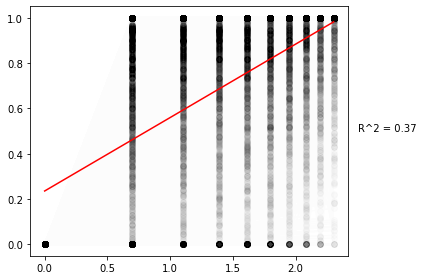

In [14]:
slope, intercept, r, p, se = st.linregress(np.log(exps+1),imms)
x = np.log(np.asarray(range(0,10))+1)
y = (x*slope) + intercept
fig,ax = plt.subplots()
ax.plot(np.log(exps+1),imms,alpha=0.01,color='k',marker='o')
ax.plot(x,y,color='red')
ax.text(2.5,0.5, "R^2 = " + "{0:.2g}".format(r**2))
fig.tight_layout()

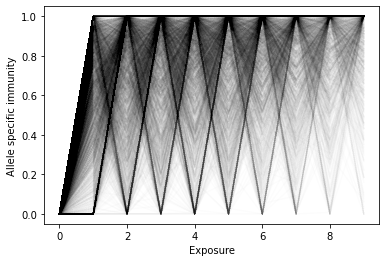

In [15]:
fig,ax = plt.subplots()
for row in range(immunity.shape[0]):
    ax.plot(immunity[row,:],alpha=0.01,color='k')
    ax.set_xlabel("Exposure")
    ax.set_ylabel("Allele specific immunity")
#fig.savefig("figs/exposure_allele-immunity.pdf")

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_11136/1597870711.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(0,10))


[Text(-1.0, 0, '0'),
 Text(0.0, 0, '1'),
 Text(1.0, 0, '2'),
 Text(2.0, 0, '3'),
 Text(3.0, 0, '4'),
 Text(4.0, 0, '5'),
 Text(5.0, 0, '6'),
 Text(6.0, 0, '7'),
 Text(7.0, 0, '8'),
 Text(8.0, 0, '9'),
 Text(9.0, 0, '')]

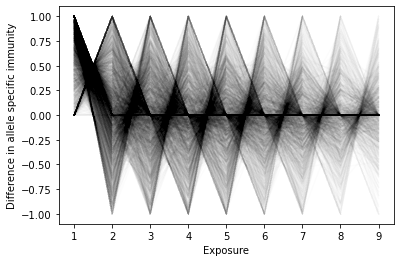

In [16]:
shifted = np.roll(immunity,1,axis=1)
diff = immunity - shifted
fig,ax = plt.subplots()
for row in range(diff.shape[0]):
    ax.plot(diff[row,1:],alpha=0.01,color='k')
ax.set_xlabel("Exposure")
ax.set_ylabel("Difference in allele specific immunity")
ax.set_xticklabels(range(0,10))
#fig.savefig("figs/exposure_diff-in-allele-immunity.pdf")

There is some correlation, but I think it's all confused by zero to 1 and from then on. Maybe we should do zero to one & one on.

Here's one on:

In [17]:
exposures = np.tile(range(0,10),immunity.shape[0])
immunity_long = immunity.flatten()
exps = []
imms = []
for e, i in zip(exposures,immunity_long):
    if not np.isnan(i) and e != 0:
        exps.append(e)
        imms.append(i)
exps = np.asarray(exps)
imms = np.asarray(imms)

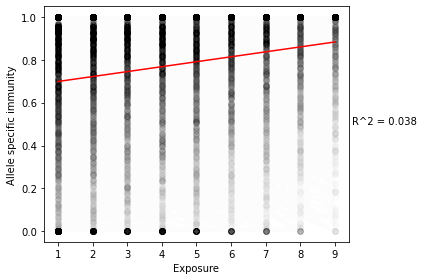

In [18]:
slope, intercept, r, p, se = st.linregress(exps,imms)
x = np.asarray(range(1,10))
y = (x*slope) + intercept
fig,ax = plt.subplots()
ax.plot(exps,imms,alpha=0.01,color='k',marker='o')
ax.plot(x,y,color='red')
ax.text(9.5,0.5, "R^2 = " + "{0:.2g}".format(r**2))
ax.set_xlabel("Exposure")
ax.set_ylabel("Allele specific immunity")
fig.tight_layout()
#fig.savefig("figs/exposure_allele-immunity_1+.pdf")

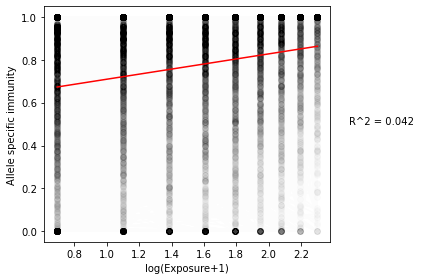

In [19]:
slope, intercept, r, p, se = st.linregress(np.log(exps+1),imms)
x = np.log(np.asarray(range(1,10))+1)
y = (x*slope) + intercept
fig,ax = plt.subplots()
ax.plot(np.log(exps+1),imms,alpha=0.01,color='k',marker='o')
ax.plot(x,y,color='red')
ax.text(2.5,0.5, "R^2 = " + "{0:.2g}".format(r**2))
ax.set_xlabel("log(Exposure+1)")
ax.set_ylabel("Allele specific immunity")
fig.tight_layout()
#fig.savefig("figs/logexposure_allele-immunity_1+.pdf")

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_11136/551210689.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1,2,3,4,5,6,7,8,9])


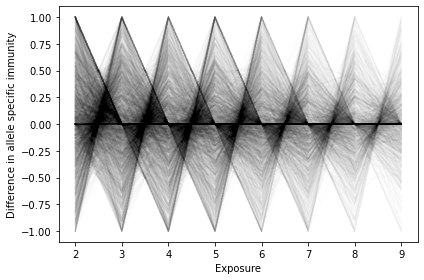

In [20]:
shifted = np.roll(immunity,1,axis=1)
diff = immunity - shifted
fig,ax = plt.subplots()
for row in range(diff.shape[0]):
    ax.plot(diff[row,2:],alpha=0.01,color='k')
ax.set_xlabel("Exposure")
ax.set_ylabel("Difference in allele specific immunity")
ax.set_xticklabels([1,2,3,4,5,6,7,8,9])
fig.tight_layout()

**Conclusions: There is no relationship in allele specific immunity and exposure in this model.**

Let's now think about that first vs. second exposure...

In [21]:
control_immunity = np.empty((max(a)*n_people,10))
control_immunity[:,:] = np.nan
counter = 0
for person in range(n_people):
    for allele in range(a[0]):
        windows= get_infection_windows(0, allele, all_parasites[person,...], infectmatrix=all_infections[person],n_infections=10,smatrix=all_strains[person])
        starts = windows[0,:]
        for i in range(10):
            if starts[i] > 0:
                control_immunity[counter,i] = all_immunity[person,0,allele,starts[i]]
        counter += 1

In [22]:
shifted_test = np.roll(immunity,1,axis=1)
diff_test = immunity - shifted_test
shifted_control = np.roll(control_immunity,1,axis=1)
diff_control = control_immunity - shifted_control

Text(0, 0.5, 'Density')

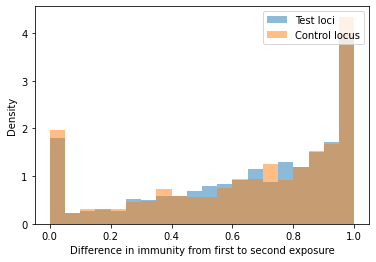

In [23]:
fig,ax = plt.subplots()
ax.hist(diff_test[:,1],histtype='stepfilled',alpha=0.5,density=True,bins=20,label="Test loci")
ax.hist(diff_control[:,1],histtype='stepfilled',alpha=0.5,density=True,bins=20,label="Control locus")
ax.legend()
ax.set_xlabel("Difference in immunity from first to second exposure")
ax.set_ylabel("Density")
#fig.savefig("figs/immune-diff_exposure2_test-control.pdf")

With control loci, there are more loci where immunity == 0 or immunity == 1 upon second exposure. I expected the latter. I did not expect the former. I think it has something to do with ordering not mattering at the conrol loci.

Since it looks like there is some correlation with immunity and exposure 0 vs. 1, I want to move on to compare how parasite density differs by exposure. At first I'll just do this at a single loci level. But I want to do it for measured parasite density and true. For true, I'll use the maximum and area under the curve. For measured, I'll try maximum, all & area under the curve...

1. Comparing maximum parasite density at first & second expsoure for real & measured.

In [28]:
y=3
a = [10,10,10,10]
w = [0,1/3,1/3,1/3]

In [53]:
def get_peaks(pdensity):
    '''
    Finds the time of all parasite density peaks
    '''
    lag = np.pad(pdensity,1,mode='constant')[:-2]
    sign = np.sign(pdensity-lag).astype(int)
    lead = np.pad(sign,(0,1), mode='constant')[1:]
    peak = np.where(sign > lead)[0]
    if len(peak)==0:
        peak = np.argmax(pdensity)
    return peak

def get_max_pdensity(pmatrix,loci,allele,window,visits=[]):
    '''
    Returns maximum parasite density in a given time_window.
    '''
    if len(visits)>0:
        visits = np.asarray(visits)
        visited = visits[(visits >= window[0]) & (visits <= window[1])]
        pdensities = pmatrix[loci,allele,visited]
        maxima = max(pdensities)
    else:
        pdensities = pmatrix[loci,allele,window[0]:window[1]+1]
        peaktimes = get_peaks(pdensities)
        maxima = pdensities[peaktimes[0]]
    return maxima

def get_max_exp1_exp2(all_parasites, all_infections, all_strains, all_malaria,y,a,test,period=28,measured=True):
    '''
    Returns arrays of maximum parasite density for exposure 1 & 2.
    If measured == True, this will be for measured maximums not true maximums.
    '''
    n_people = len(all_parasites)
    test_1 = []
    test_2 = []
    control_1 = []
    control_2 = []
    
    for person in range(n_people):
        if measured==True:
            visits = get_visits(all_malaria[person],period,y)
        else:
            visits = []
        
        # Control loci
        counter = 0
        for allele in range(a[0]): ## SPEED UP by doing get-infection-windows for all alleles all at once.
            windows = get_infection_windows(0,allele,all_parasites[person,...],visits=visits,infectmatrix=all_infections[person],smatrix=all_strains[person])
            if np.all(windows[:,0]>=0):
                control_1.append(get_max_pdensity(all_parasites[person,...],0,allele,windows[:,0], visits=visits))
            else:
                control_1.append(0)
            if np.all(windows[:,1]>= 0): # WHY IS THIS NOT WORKING
                control_2.append(get_max_pdensity(all_parasites[person,...],0,allele,windows[:,1], visits=visits))
            else:
                control_2.append(0)
            counter += 1

        # Test loci
        counter = 0
        #test_loci = len(a)-1
        for allele in range(a[test]):
            windows = get_infection_windows(test,allele,all_parasites[person,...],visits=visits,infectmatrix=all_infections[person],smatrix=all_strains[person])
            if np.all(windows[:,0] >=0):
                test_1.append(get_max_pdensity(all_parasites[person,...],test,allele,windows[:,0], visits=visits))
            else:
                test_1.append(0)
            if np.all(windows[:,1] >=0):
                test_2.append(get_max_pdensity(all_parasites[person,...],test,allele,windows[:,1], visits=visits))
            else:
                test_2.append(0)
            counter += 1
    
    return control_1,control_2,test_1,test_2

In [30]:
ctrl1,ctrl2,test1,test2 = get_max_exp1_exp2(all_parasites,all_infections,all_strains, all_malaria,y,a,len(a)-1,measured=False)

In [31]:
def get_log(arr):
    new_arr = [np.log10(value) if value != 0 else -3 for value in arr]
    return np.asarray(new_arr)

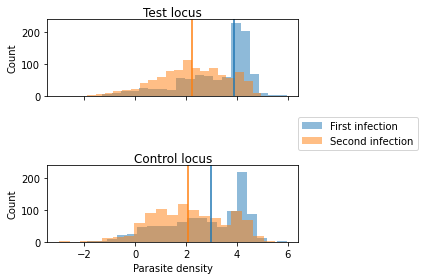

In [32]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True,tight_layout=True)

ax[0].hist(get_log(test1),histtype='stepfilled',alpha=0.5,bins=20,label="First infection")
ax[0].hist(get_log(test2),histtype='stepfilled',alpha=0.5,bins=20,label="Second infection")
ax[1].hist(get_log(ctrl1),histtype='stepfilled',alpha=0.5,bins=20,label="First infection")
ax[1].hist(get_log(ctrl2),histtype='stepfilled',alpha=0.5,bins=20,label="Second infection")
ax[0].axvline(np.median(get_log(test1)))
ax[0].axvline(np.median(get_log(test2)),color="tab:orange")
ax[1].axvline(np.median(get_log(ctrl1)))
ax[1].axvline(np.median(get_log(ctrl2)),color="tab:orange")

ax[1].set_xlabel("Parasite density")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
ax[0].set_title("Test locus",pad=3)
ax[1].set_title("Control locus",pad=-10)
ax[1].legend(loc=(1,1.2))

In [33]:
diff_control = get_log(ctrl2) - get_log(ctrl1)
diff_test = get_log(test2) - get_log(test1)
s,pvalue =st.mannwhitneyu(x=diff_control,y=diff_test)

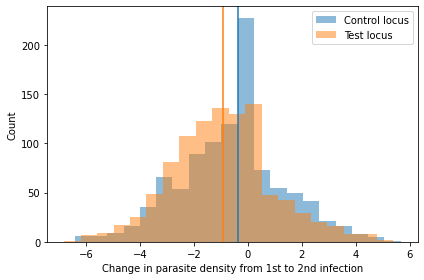

In [34]:
fig,ax = plt.subplots(tight_layout=True)

ax.hist(diff_control,histtype='stepfilled',alpha=0.5,bins=20,label="Control locus")
ax.hist(diff_test,histtype='stepfilled',alpha=0.5,bins=20,label="Test locus")
ax.axvline(np.median(diff_control))
ax.axvline(np.median(diff_test),color="tab:orange")

ax.set_xlabel("Change in parasite density from 1st to 2nd infection")
ax.set_ylabel("Count")
ax.legend()

In [35]:
def set_axis_style(ax, lab):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(ticks = np.arange(1, len(lab) + 1))
    ax.set_xticklabels(lab)
    ax.set_xlim(0.25, len(lab) + 0.75)

Text(1.2, 4, 'Mann Whitney U Test\np-value = 6.69e-07')

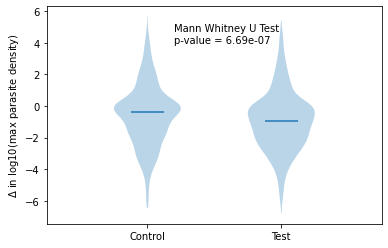

In [36]:
lab = ["Control", "Test"]
fig,ax = plt.subplots()
ax.violinplot([diff_control,diff_test],showextrema=False,showmedians=True)
set_axis_style(ax,lab)
ax.set_ylabel(r'$\Delta$ in log10(max parasite density)')
ax.text(1.2,4,"Mann Whitney U Test\np-value = " + "{:.2e}".format(pvalue))
#fig.savefig("figs/delta-parasite-density_control_test_true.pdf")

In [37]:
ctrl1,ctrl2,test1,test2 = get_max_exp1_exp2(all_parasites,all_infections,all_malaria,y,a,measured=True)

TypeError: get_max_exp1_exp2() missing 2 required positional arguments: 'a' and 'test'

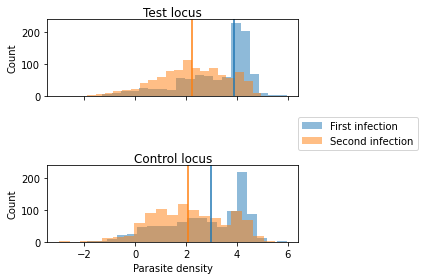

In [38]:
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True,tight_layout=True)

ax[0].hist(get_log(test1),histtype='stepfilled',alpha=0.5,bins=20,label="First infection")
ax[0].hist(get_log(test2),histtype='stepfilled',alpha=0.5,bins=20,label="Second infection")
ax[1].hist(get_log(ctrl1),histtype='stepfilled',alpha=0.5,bins=20,label="First infection")
ax[1].hist(get_log(ctrl2),histtype='stepfilled',alpha=0.5,bins=20,label="Second infection")
ax[0].axvline(np.median(get_log(test1)))
ax[0].axvline(np.median(get_log(test2)),color="tab:orange")
ax[1].axvline(np.median(get_log(ctrl1)))
ax[1].axvline(np.median(get_log(ctrl2)),color="tab:orange")

ax[1].set_xlabel("Parasite density")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
ax[0].set_title("Test locus",pad=3)
ax[1].set_title("Control locus",pad=-10)
ax[1].legend(loc=(1,1.2))

In [39]:
diff_control = get_log(ctrl2) - get_log(ctrl1)
diff_test = get_log(test2) - get_log(test1)
s,pvalue =st.mannwhitneyu(x=diff_control,y=diff_test)

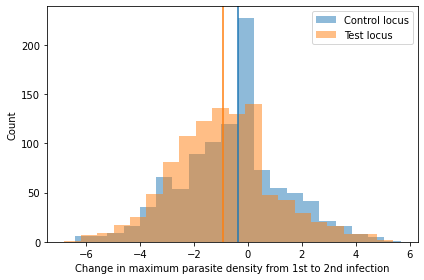

In [40]:
fig,ax = plt.subplots(tight_layout=True)

ax.hist(diff_control,histtype='stepfilled',alpha=0.5,bins=20,label="Control locus")
ax.hist(diff_test,histtype='stepfilled',alpha=0.5,bins=20,label="Test locus")
ax.axvline(np.median(diff_control))
ax.axvline(np.median(diff_test),color="tab:orange")

ax.set_xlabel("Change in maximum parasite density from 1st to 2nd infection")
ax.set_ylabel("Count")
ax.legend()

Text(1.2, 4, 'Mann Whitney U test\np-value = 6.69e-07')

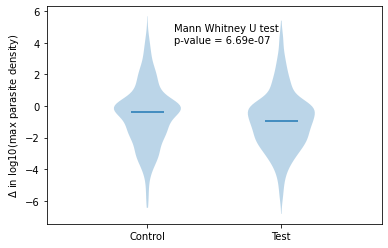

In [41]:
lab = ["Control", "Test"]
fig,ax = plt.subplots()
ax.violinplot([diff_control,diff_test],showextrema=False,showmedians=True)
set_axis_style(ax,lab)
ax.set_ylabel(r'$\Delta$ in log10(max parasite density)')
ax.text(1.2,4,"Mann Whitney U test\np-value = " + "{:.2e}".format(pvalue))
#fig.savefig("figs/delta-parasite-density_control_test_measured.pdf")

In [38]:
## NEXT STEP: then power calc --> then as a multiple regression

In [39]:
## Then as --> area, measured vs. real

In [48]:
def get_pvalue_1st2nd(all_parasites,all_infections,all_strains,all_malaria,y,a,l,measured):
    '''
    Returns pvalue of Mann-Whitney U Test comparing diff in parasite density for first vs. second infection at test loci compared to control loci.
    '''
    ctrl1,ctrl2,test1,test2 = get_max_exp1_exp2(all_parasites,all_infections,all_strains,all_malaria,y,a,l,measured=measured)
    diff_control = get_log(ctrl2) - get_log(ctrl1)
    diff_test = get_log(test2) - get_log(test1)
    s,pvalue =st.mannwhitneyu(x=diff_control,y=diff_test)
    return pvalue

def get_sens_spec(control, test, cutoff):
    '''
    Returns sensitivity & specificity of a test given some cutoff.
    '''
    test = np.asarray(test)
    control = np.asarray(control)
    tp = np.count_nonzero(test < cutoff)
    fp = np.count_nonzero(control < cutoff)
    tn = len(control) - fp
    fn = len(test) - tp
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    return sens, spec
    

def power_calc_1st2nd(y,a,w,cutoff=0.05,measured=True):
    '''
    Returns sensitivity & specificity for 10**x number of people.
    Test = Diff in parasite density at first vs. second exposure.
    x = range(0,4)
    '''
    people = []
    sensitivity = []
    specificity = []
    intervals = [10,50,100,500]
    #intervals= [100]
    for n_people in intervals:
        print('n_people: ' + str(n_people))
        control_pvalue = []
        test_pvalue = []
        for experiment in range(1):
            all_parasites, all_immunity, all_strains, all_malaria, all_infections = tent.simulate_cohort(n_people,y,a,w)
            for l in [1,len(a)-1]:
                pvalue = get_pvalue_1st2nd(all_parasites,all_infections,all_strains,all_malaria,y,a,l,measured=measured)
                if l == 1:
                    control_pvalue.append(pvalue)
                else:
                    test_pvalue.append(pvalue)
        sens, spec = get_sens_spec(control_pvalue,test_pvalue,cutoff)
        sensitivity.append(sens)
        specificity.append(spec)
        people.append(n_people)
    
    df = pd.DataFrame({'n_people':people,'sensitivity':sensitivity, 'specificity':specificity})
    return df

In [43]:
%load_ext line_profiler

In [51]:
results = pd.DataFrame()
intervals = [1,5,10,25,50,100]
for n_loci in intervals:
    a = list(np.repeat(10,2+n_loci))
    w = [0,0]
    i_w = list(np.repeat(1/n_loci,n_loci))
    w.extend(i_w)
    print('n_loci: ' + str(n_loci))
    df = power_calc_1st2nd(y,a,w)
    df['n_immloci'] = n_loci
    df['weight'] = w[-1]
    results.append(df)

n_loci: 1
n_people: 10
n_people: 50
n_people: 100
n_people: 500
n_loci: 5
n_people: 10
n_people: 50
n_people: 100
n_people: 500


KeyboardInterrupt: 

In [52]:
intervals = [1,5,10,25,50,100]
y=3

def loci_pc(intervals,y):
    results = pd.DataFrame()
    for n_loci in intervals:
        a = list(np.repeat(10,2+n_loci))
        w = [0,0]
        i_w = list(np.repeat(1/n_loci,n_loci))
        w.extend(i_w)
        print('n_loci: ' + str(n_loci))
        df = power_calc_1st2nd(y,a,w)
        df['n_immloci'] = n_loci
        df['weight'] = w[-1]
        results.append(df)
    return results
%lprun -f loci_pc loci_pc(intervals,y)


n_loci: 1
n_people: 10
n_people: 50
n_people: 100
n_people: 500
n_loci: 5
n_people: 10
n_people: 50
n_people: 100
n_people: 500
n_loci: 10
n_people: 10
n_people: 50
n_people: 100
n_people: 500
n_loci: 25
n_people: 10
n_people: 50
n_people: 100
n_people: 500
n_loci: 50
n_people: 10
n_people: 50
n_people: 100
n_people: 500
n_loci: 100
n_people: 10
n_people: 50
n_people: 100
n_people: 500


Timer unit: 1e-06 s

Total time: 175.175 s
File: /var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_11136/1206784474.py
Function: loci_pc at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def loci_pc(intervals,y):
     5         1       1596.0   1596.0      0.0      results = pd.DataFrame()
     6         7          8.0      1.1      0.0      for n_loci in intervals:
     7         6        143.0     23.8      0.0          a = list(np.repeat(10,2+n_loci))
     8         6          5.0      0.8      0.0          w = [0,0]
     9         6         73.0     12.2      0.0          i_w = list(np.repeat(1/n_loci,n_loci))
    10         6          9.0      1.5      0.0          w.extend(i_w)
    11         6       1228.0    204.7      0.0          print('n_loci: ' + str(n_loci))
    12         6  175159116.0 29193186.0    100.0          df = power_calc_1st2nd(y,a,w)
    13         6       5756.0    959.3      0.0

In [51]:
y=3
n_loci = 10
a = list(np.repeat(10,2+n_loci))
w = [0,0]
i_w = list(np.repeat(1/n_loci,n_loci))
w.extend(i_w)

%lprun -f get_max_exp1_exp2 power_calc_1st2nd(y,a,w)

n_people: 10
n_people: 50
n_people: 100
n_people: 500


Timer unit: 1e-06 s

Total time: 2.33542 s
File: /var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_11136/3108496653.py
Function: get_max_exp1_exp2 at line 28

Line #      Hits         Time  Per Hit   % Time  Line Contents

Save DF & turn into script!!!!!!

In [ ]:
### I'm trying to speed up my code, so I actually can run power calcs

In [ ]:
### current time is 299 sec, I need to get that to 84 sec